In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def update(s, i, d):
    s_new = s + i - d
    return s_new

def buy_cost(i,t):
    if t <= 5:
        return i
    else:
        return 3*i

def relu(x):
    return tf.nn.relu(x)

def penalty(x, gamma):
    return tf.where(tf.less(x, 0.), gamma * tf.abs(x), 0.)

class StorePred(tf.keras.Model):
    def __init__(self, T, smax, imax, gamma, d_array, batch_size, hidden_units=100):
        super(StorePred, self).__init__()
        self.T = T
        self.smax = smax
        self.imax = imax
        self.gamma = gamma
        self.d_array = d_array
        self.batch_size = batch_size
        self.call_id = 0

        self.network_layers=[]
        for _ in range(T):
            self.network_layers.append(tf.keras.layers.Dense(hidden_units, activation=None, kernel_initializer='random_normal'))
            self.network_layers.append(tf.keras.layers.BatchNormalization())
            self.network_layers.append(tf.keras.layers.Dense(hidden_units, activation=None, kernel_initializer='random_normal'))
            self.network_layers.append(tf.keras.layers.BatchNormalization())
            self.network_layers.append(tf.keras.layers.Dense(1, activation='relu', kernel_initializer='random_normal'))

    def call(self, input, training=False):
        s = input
        cost = tf.zeros(s.shape)
        for t in range(self.T):
            s = tf.reshape(s,(-1,1))
            x = self.network_layers[t*5](s) # input to hidden layer
            x = self.network_layers[t*5+1](x, training=training) # batch norm
            x = relu(x)
            x = self.network_layers[t*5+2](x) # hidden to hidden layer
            x = self.network_layers[t*5+3](x, training=training) # batch norm
            x = relu(x)
            i = self.network_layers[t*5+4](x) # hidden to output layer
            d = tf.reshape(self.d_array[self.call_id*self.batch_size:(self.call_id+1)*self.batch_size,t],s.shape)
            cost += buy_cost(i,t) + penalty(s, self.gamma) + penalty(self.smax - s, self.gamma) \
                    + penalty(i, self.gamma) + penalty(self.imax - i, self.gamma) + penalty(s + i - d, self.gamma)
            s = update(s, i, d)
        cost += penalty(s, self.gamma) + penalty(self.smax - s, self.gamma)
        self.call_id += 1
        return cost

2023-05-09 17:03:37.217649: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.random.set_seed(42)

T = 10 # number of subnetworks

s_0 = 50. # initial value of s_0
gamma = 1e4 # penalty parameter
smax = 100. # maximum value of s_t
imax = 30. # maximum value of i_t
learning_rate = 0.003 # learning rate for SGD
num_epochs = 1000
batch_size = 50
n_it_steps = 20000
N = int(batch_size * n_it_steps / num_epochs) # training set size

# Initial state and labels
inputs = tf.constant(s_0 * np.ones((N,1)), dtype=tf.float32)
outputs = tf.constant(np.zeros_like(inputs))

# Demand
d_array = tf.random.uniform(shape=(N,T), minval=5, maxval=35, dtype=tf.float32)
d_array = tf.floor(d_array)

# Instantiate model
model = StorePred(T, smax, imax, gamma, d_array, batch_size, hidden_units=50)

# Define loss function and optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_function = tf.keras.losses.MeanAbsoluteError()
metric = [tf.keras.metrics.MeanAbsoluteError()]

model.compile(optimizer=optimizer, loss=loss_function, metrics=metric)
# model.build((batch_size,1))
#model.summary()

2023-05-09 17:03:47.635302: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Train the model
history = model.fit(x=inputs, y=outputs, batch_size=batch_size, epochs=num_epochs)

Epoch 1/1000
20/20 [==============================] - 12s 9ms/step - loss: 11759546.0000 - mean_absolute_error: 11759546.0000
Epoch 2/1000
20/20 [==============================] - 0s 8ms/step - loss: 10443443.0000 - mean_absolute_error: 10443443.0000
Epoch 3/1000
20/20 [==============================] - 0s 7ms/step - loss: 8439516.0000 - mean_absolute_error: 8439516.0000
Epoch 4/1000
20/20 [==============================] - 0s 7ms/step - loss: 5897914.0000 - mean_absolute_error: 5897914.0000
Epoch 5/1000
20/20 [==============================] - 0s 10ms/step - loss: 3022695.7500 - mean_absolute_error: 3022696.2500
Epoch 6/1000
20/20 [==============================] - 0s 6ms/step - loss: 580664.2500 - mean_absolute_error: 580664.2500
Epoch 7/1000
20/20 [==============================] - 0s 6ms/step - loss: 8000.0459 - mean_absolute_error: 8000.0459
Epoch 8/1000
20/20 [==============================] - 0s 6ms/step - loss: 1067.6405 - mean_absolute_error: 1067.6405
Epoch 9/1000
20/20 [====

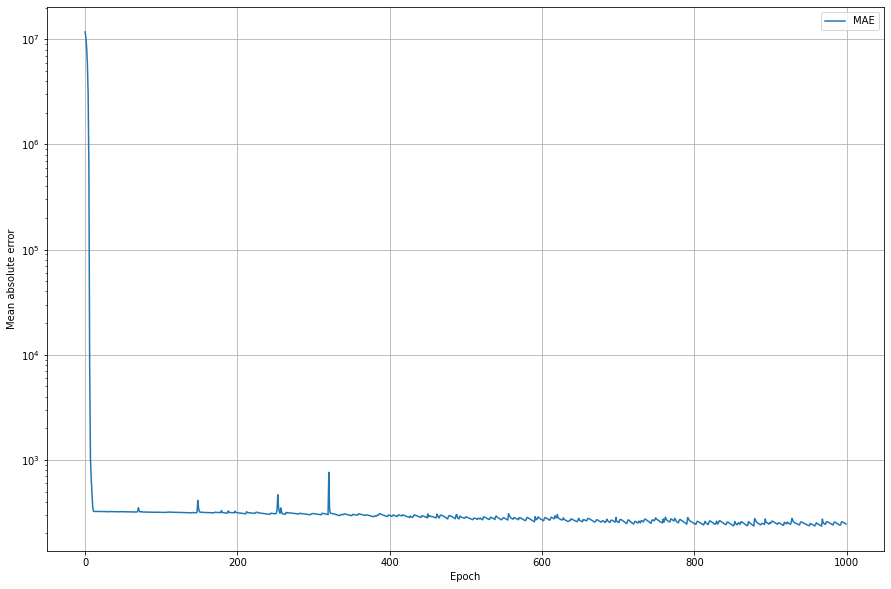

In [4]:
plt.figure('Error', figsize=(15, 10))
plt.semilogy(history.history['mean_absolute_error'], label='MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean absolute error')
plt.legend()
plt.grid(True)
#plt.savefig('mae_test2.png', dpi=150)
plt.show()

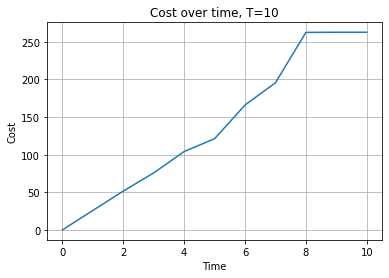

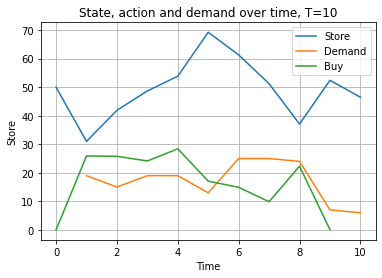

In [5]:
tf.random.set_seed(12)
# Initial state and labels
s = tf.constant(s_0 * np.ones((1,1)), dtype=tf.float32)

# Demand
d_array = tf.random.uniform(shape=(1,T), minval=5, maxval=35, dtype=tf.float32)
d_array = tf.floor(d_array)

# Predict
costs = np.zeros(T+1)
store = np.zeros(T+1)
demand = np.zeros(T)
buy = np.zeros(T)

cost = tf.zeros(s.shape)
for t in range(model.T):
    s = tf.reshape(s,(-1,1))
    x = model.network_layers[t*5](s) # input to hidden layer
    x = model.network_layers[t*5+1](x, training=False) # batch norm
    x = relu(x)
    x = model.network_layers[t*5+2](x) # hidden to hidden layer
    x = model.network_layers[t*5+3](x, training=False) # batch norm
    x = relu(x)
    i = model.network_layers[t*5+4](x) # hidden to output layer
    # i = tf.floor(i)
    # i = tf.cast(i, tf.float32)
    d = d_array[0,t]
    cost += buy_cost(i,t) + penalty(s, model.gamma) + penalty(model.smax - s, model.gamma) + penalty(i, model.gamma) + penalty(model.imax - i, model.gamma) + penalty(s + i - d, model.gamma)
    costs[t] = cost
    store[t] = s
    demand[t] = d
    buy[t] = i
    s = update(s, i, d)
store[T] = s
cost += penalty(s, model.gamma) + penalty(model.smax - s, model.gamma)
costs[T] = cost
    

plt.figure('Cost')
plt.plot(costs, label='Cost')
plt.xlabel('Time')
plt.ylabel('Cost')
plt.title('Cost over time, T=10')
plt.grid(True)
plt.show()

plt.figure('Store')
plt.plot(range(T+1),store, label='Store')
plt.plot(range(1,T+1),demand, label='Demand')
plt.plot(buy, label='Buy')
plt.xlabel('Time')
plt.ylabel('Store')
plt.legend()
plt.title('State, action and demand over time, T=10')
plt.grid(True)
plt.show()